In [1]:
import os
os.chdir(os.getcwd())

In [2]:
#limit VRAM usage
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2023-03-20 15:18:56.301968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 15:18:56.853877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rishabh/miniconda3/envs/tf/lib/
2023-03-20 15:18:56.854468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rishabh/miniconda3/envs/tf/lib/
2023-03-20 15:18:56.854475: W tensorflow/compiler/tf2tens

In [3]:
#check and remove dodgy images from dataset
import cv2
import imghdr

data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image extension not supported: ', format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: ', format(image_path))

In [4]:
#creating a dataset using keras and all the images in the data folder
import numpy as np
from matplotlib import pyplot as plt
#building a data pipeline
data = tf.keras.utils.image_dataset_from_directory('data')

#scaling the data to be between 0 and 1 from 0 to 255
# logic - scaled = batch[0] / 255 but we apply this directly to the pipeline
data = data.map(lambda x, y: (x / 255, y)) # type: ignore

Found 47009 files belonging to 2 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-20 15:19:21.839710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 15:19:21.840166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 15:19:21.840342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 15:19:21.840470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [5]:
#making it an interator to allow us to loop through the data
data_iterator = data.as_numpy_iterator() # type: ignore
#grab a batch of data
batch = data_iterator.next()
#batch[0].shape #shape of the images
batch[1] 
# Classification labels: 0 - Female, 1 - Male.

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

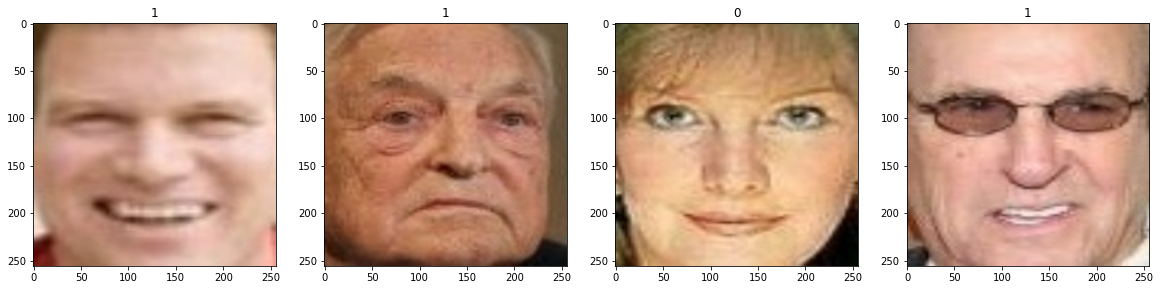

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    #ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    #ax[idx].title.set_text(batch[1][idx])

In [7]:
len(data)

1470

In [17]:
#making training, validation and test sets, they all add up to len(data) = 1470 in this case
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size) # type: ignore
val = data.skip(train_size).take(val_size) # type: ignore
test = data.skip(train_size+val_size).take(test_size) # type: ignore

In [18]:
#building the model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

In [19]:
#training the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
1029/1029 [==============================] - 25s 23ms/step - loss: 0.2856 - accuracy: 0.8823 - val_loss: 0.2010 - val_accuracy: 0.9190
Epoch 2/20
1029/1029 [==============================] - 23s 23ms/step - loss: 0.1625 - accuracy: 0.9390 - val_loss: 0.1678 - val_accuracy: 0.9373
Epoch 3/20
1029/1029 [==============================] - 24s 23ms/step - loss: 0.1200 - accuracy: 0.9559 - val_loss: 0.1724 - val_accuracy: 0.9374
Epoch 4/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.0825 - accuracy: 0.9698 - val_loss: 0.1949 - val_accuracy: 0.9377
Epoch 5/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.0551 - accuracy: 0.9805 - val_loss: 0.2361 - val_accuracy: 0.9338
Epoch 6/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.0408 - accuracy: 0.9860 - val_loss: 0.2724 - val_accuracy: 0.9348
Epoch 7/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.0276 - accuracy: 0.9905 - val_loss: 0.3416 -

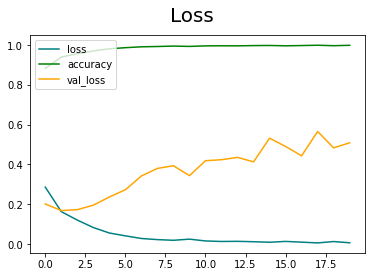

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

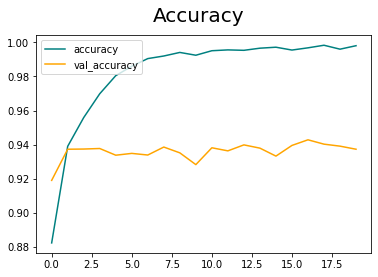

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [26]:
#Evaluate the model performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy # type: ignore
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
len(test)

147

In [27]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 68ms/step


In [28]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9455319046974182, Recall: 0.9289297461509705, Accuracy: 0.936229407787323


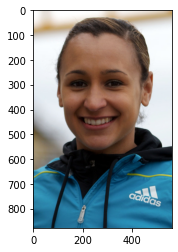

In [39]:
#Test the model
img = cv2.imread('ftest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

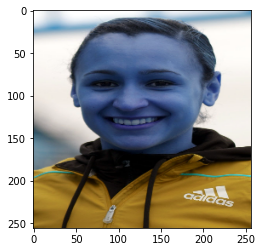

In [40]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int)) # type: ignore
plt.show()

In [41]:
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 12ms/step
[[1.0658853e-05]]
prediction: Female


In [42]:
#Save the model
from tensorflow.keras.models import load_model
model.save(os.path.join('models','gender_classifier.h5'))

In [43]:
#Load the saved model
new_model = load_model(os.path.join('models','gender_classifier.h5'))
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 44ms/step
prediction: Female
